# CheXpert Data Exploration

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from keras_preprocessing.image import ImageDataGenerator
from keras import layers
from keras import models
from keras import optimizers

In [26]:
#read in the training dataset
train=pd.read_csv("CheXpert-v1.0-small/train.csv", dtype = str)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223414 entries, 0 to 223413
Data columns (total 19 columns):
Path                          223414 non-null object
Sex                           223414 non-null object
Age                           223414 non-null object
Frontal/Lateral               223414 non-null object
AP/PA                         191027 non-null object
No Finding                    22381 non-null object
Enlarged Cardiomediastinum    44839 non-null object
Cardiomegaly                  46203 non-null object
Lung Opacity                  117778 non-null object
Lung Lesion                   11944 non-null object
Edema                         85956 non-null object
Consolidation                 70622 non-null object
Pneumonia                     27608 non-null object
Atelectasis                   68443 non-null object
Pneumothorax                  78934 non-null object
Pleural Effusion              133211 non-null object
Pleural Other                 6492 non-null object

In [27]:
train.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


## Data Prep

In [28]:
## clean up the pathologies
pathology = ['No Finding','Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture','Support Devices']
#mapping to different labels
labelMap = {'0.0': 0, '1.0' : 1, '-1.0' : 1}

for p in pathology:
    train[p].loc[train[p].isna()] = '0.0'
    train[p] = train[p].map(labelMap)
    
##clean up the age to int then create buckets
train['Age'] = train['Age'].astype(str).astype(int)
age_buckets = [0, 2, 5, 13, 18, 33, 48, 64, 78, 98]
train['age_bucket'] = pd.cut(train['Age'], age_buckets)

##parse the path into the respective categories
new = train["Path"].str.split("/", n = 5, expand = True)

train['Folder'] = new[0]
train['Data'] = new[1]
train['Patient'] = new[2]
train['Study'] = new[3]
train['viewNumber']= new[4].str.split("_", n = 2, expand = True)[0]
train['ImageType']= new[4].str.split("_", n = 2, expand = True)[1]

train.head()

/home/newall/anaconda3/envs/tensorflow/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,...,Pleural Other,Fracture,Support Devices,age_bucket,Folder,Data,Patient,Study,viewNumber,ImageType
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1,0,0,0,0,...,0,0,1,"(64, 78]",CheXpert-v1.0-small,train,patient00001,study1,view1,frontal.jpg
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,0,0,1,1,0,...,0,1,0,"(78, 98]",CheXpert-v1.0-small,train,patient00002,study2,view1,frontal.jpg
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,0,0,0,1,0,...,0,1,0,"(78, 98]",CheXpert-v1.0-small,train,patient00002,study1,view1,frontal.jpg
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,0,0,0,1,0,...,0,1,0,"(78, 98]",CheXpert-v1.0-small,train,patient00002,study1,view2,lateral.jpg
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,0,0,0,0,0,...,0,0,0,"(33, 48]",CheXpert-v1.0-small,train,patient00003,study1,view1,frontal.jpg


## Age Buckets

[]

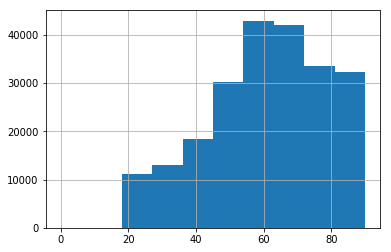

In [29]:
train['Age'].hist().plot()

In [37]:
volumes = train.groupby(['Sex','age_bucket']).size()
volumes

Sex      age_bucket
Female   (13, 18]        290
         (18, 33]       8291
         (33, 48]      13291
         (48, 64]      27042
         (64, 78]      23332
         (78, 98]      18528
Male     (13, 18]        476
         (18, 33]      12141
         (33, 48]      19382
         (48, 64]      44298
         (64, 78]      35562
         (78, 98]      20777
Unknown  (33, 48]          1
dtype: int64

In [36]:
propPleural = train.groupby(['Sex','age_bucket'])['Pleural Effusion'].mean()
propPleural

Sex      age_bucket
Female   (13, 18]      0.331034
         (18, 33]      0.305271
         (33, 48]      0.360169
         (48, 64]      0.440907
         (64, 78]      0.489414
         (78, 98]      0.501619
Male     (13, 18]      0.279412
         (18, 33]      0.305411
         (33, 48]      0.366474
         (48, 64]      0.434218
         (64, 78]      0.478179
         (78, 98]      0.509265
Unknown  (33, 48]      0.000000
Name: Pleural Effusion, dtype: float64

In [27]:
train['ImageType'].value_counts()

frontal.jpg    191027
lateral.jpg     32387
Name: ImageType, dtype: int64

In [21]:
patients = train.groupby(['Patient'])['Study'].nunique()
patients.head()

Patient
patient00001    1
patient00002    2
patient00003    1
patient00004    1
patient00005    2
Name: Study, dtype: int64

<bound method Axes.plot of <matplotlib.axes._subplots.AxesSubplot object at 0x7f5f012b9978>>

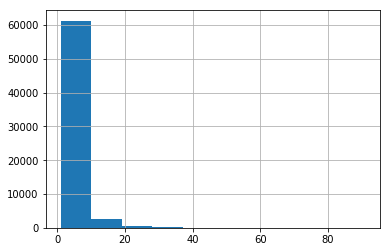

In [23]:
patients.hist().plot

In [8]:
pathology = ['No Finding','Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture','Support Devices']

for p in pathology:
    print(train[p].value_counts())

No Finding
0.0    201033
1.0     22381
Name: No Finding, dtype: int64
Enlarged Cardiomediastinum
0.0     200213
-1.0     12403
1.0      10798
Name: Enlarged Cardiomediastinum, dtype: int64
Cardiomegaly
0.0     188327
1.0      27000
-1.0      8087
Name: Cardiomegaly, dtype: int64
Lung Opacity
0.0     112235
1.0     105581
-1.0      5598
Name: Lung Opacity, dtype: int64
Lung Lesion
0.0     212740
1.0       9186
-1.0      1488
Name: Lung Lesion, dtype: int64
Edema
0.0     158184
1.0      52246
-1.0     12984
Name: Edema, dtype: int64
Consolidation
0.0     180889
-1.0     27742
1.0      14783
Name: Consolidation, dtype: int64
Pneumonia
0.0     198605
-1.0     18770
1.0       6039
Name: Pneumonia, dtype: int64
Atelectasis
0.0     156299
-1.0     33739
1.0      33376
Name: Atelectasis, dtype: int64
Pneumothorax
0.0     200821
1.0      19448
-1.0      3145
Name: Pneumothorax, dtype: int64
Pleural Effusion
0.0     125599
1.0      86187
-1.0     11628
Name: Pleural Effusion, dtype: int64
Pleura